In [ ]:
!pip install -q sentence-transformers datasets transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 33.6 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib seaborn

In [ ]:
!pip install faiss-gpu-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 30.2 MB/s eta 0:00:00


In [ ]:
import os
import torch
import faiss
import numpy as np
import time
import pickle
import gradio as gr
from tqdm.notebook import tqdm
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
LLM_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
INDEX_TYPE = "IndexFlatIP" # Inner Product (Cosine Similarity)
BATCH_SIZE = 128
TOP_K_RETRIEVAL = 3
INDEX_FILE = "pubmed_rag_index.bin"
DATA_FILE = "pubmed_rag_data.pkl"

In [ ]:
class PubMedRAG:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Initializing RAG Pipeline on {self.device}")

        # 1. Load Embedding Model
        print(f"Loading Embedding Model: {EMBEDDING_MODEL_NAME}")
        self.embedder = SentenceTransformer(EMBEDDING_MODEL_NAME, device=self.device)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # 2. Load LLM (4-bit quantized)
        print(f"Loading LLM: {LLM_MODEL_NAME}")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
        )
        self.tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME)
        self.llm = AutoModelForCausalLM.from_pretrained(
            LLM_MODEL_NAME,
            quantization_config=bnb_config,
            device_map="auto"
        )

        # 3. Initialize placeholders
        self.index = None
        self.documents = []
        self.labeled_data = []

    def load_and_index_data(self):
        """Loads data. Tries to load from disk first; otherwise builds from scratch."""

        # --- OPTION A: LOAD FROM DISK ---
        if os.path.exists(INDEX_FILE) and os.path.exists(DATA_FILE):
            print(f"\nFound saved index and data on disk!")
            print(f"   - Loading Index from {INDEX_FILE}")
            self.index = faiss.read_index(INDEX_FILE)

            # Move to GPU if possible
            if self.device == "cuda" and hasattr(faiss, "StandardGpuResources"):
                try:
                    res = faiss.StandardGpuResources()
                    self.index = faiss.index_cpu_to_gpu(res, 0, self.index)
                    print("   Index moved to GPU.")
                except Exception as e:
                    print(f"   GPU move failed ({e}), keeping on CPU.")

            print(f"   - Loading Data from {DATA_FILE}...")
            with open(DATA_FILE, "rb") as f:
                saved_data = pickle.load(f)
                self.documents = saved_data["documents"]
                self.labeled_data = saved_data["labeled_data"]
            print("State restored.")
            return

        # --- OPTION B: BUILD FROM SCRATCH ---
        print("\nLoading Datasets from Hugging Face")
        ds_labeled = load_dataset("qiaojin/PubmedQA", "pqa_labeled", split="train")
        ds_unlabeled = load_dataset("qiaojin/PubmedQA", "pqa_unlabeled", split="train")
        ds_artificial = load_dataset("qiaojin/PubmedQA", "pqa_artificial", split="train")

        print(f"   - Labeled: {len(ds_labeled)}")
        print(f"   - Unlabeled: {len(ds_unlabeled)}")
        print(f"   - Artificial: {len(ds_artificial)}")

        def process_split(dataset, split_name):
            docs = []
            for item in tqdm(dataset, desc=f"Processing {split_name}"):
                full_text = " ".join(item['context']['contexts'])
                question_text = item.get('question', "")
                if not question_text and split_name == "labeled":
                     question_text = item.get('question', "No Question Found")

                docs.append({
                    "text": full_text,
                    "pubid": item['pubid'],
                    "question": question_text,
                    "final_decision": item.get('final_decision', None)
                })
            return docs

        self.labeled_data = process_split(ds_labeled, "labeled")
        all_docs = []
        all_docs.extend(self.labeled_data)
        all_docs.extend(process_split(ds_unlabeled, "unlabeled"))
        all_docs.extend(process_split(ds_artificial, "artificial"))

        self.documents = all_docs
        print(f"Total Documents: {len(self.documents)}")

        print("\nGenerating Embeddings")
        texts = [d['text'] for d in self.documents]
        embeddings = self.embedder.encode(
            texts,
            batch_size=BATCH_SIZE,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        print(f"\nBuilding FAISS {INDEX_TYPE} Index")
        index_flat = faiss.IndexFlatIP(self.embedding_dim)
        index_flat.add(embeddings)

        # Save to disk
        print("Saving to disk for future runs")
        faiss.write_index(index_flat, INDEX_FILE)
        with open(DATA_FILE, "wb") as f:
            pickle.dump({"documents": self.documents, "labeled_data": self.labeled_data}, f)

        # Enable GPU
        if self.device == "cuda" and hasattr(faiss, "StandardGpuResources"):
            try:
                res = faiss.StandardGpuResources()
                self.index = faiss.index_cpu_to_gpu(res, 0, index_flat)
            except:
                self.index = index_flat
        else:
            self.index = index_flat

    def retrieve(self, query, k=TOP_K_RETRIEVAL):
        query_vec = self.embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        distances, indices = self.index.search(query_vec, k)
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                results.append(self.documents[idx])
        return results

    def generate_response(self, query, retrieved_docs, mode="detailed"):
        context_text = "\n\n".join([f"Abstract {i+1}: {doc['text']}" for i, doc in enumerate(retrieved_docs)])

        # 1. Define System & User Prompts
        if mode == "benchmark":
            sys_msg = (
                "Answer in just one word based on the given context.Do not provide any explanation. You final answer should be one of 3 words: yes, no, maybe"
            )
            temp = 0.6
            max_tokens = 2048
            rep_penalty = 1.1

        else:
            sys_msg = (
                "You are a helpful medical assistant. Answer the user's question based on the provided medical abstracts. "
                "Cite the abstracts by number if necessary. Be concise."
            )
            temp = 0.6
            max_tokens = 1024
            rep_penalty = 1.1

        # 2. Create Chat Structure (Standard for Llama/DeepSeek)
        messages = [
            {"role": "system", "content": sys_msg},
            {"role": "user", "content": f"Contexts:\n{context_text}\n\nQuestion: {query}"}
        ]

        # 3. Apply Chat Template (Handles special tokens like <|begin_of_text|>)
        inputs = self.tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(self.device)

        # 4. Generate
        outputs = self.llm.generate(
    inputs,
    max_new_tokens=max_tokens,
    temperature=temp,
    top_p=1.0,
    do_sample=False if mode=="benchmark" else True,
    repetition_penalty=rep_penalty,
)

        # 5. Decode ONLY the new tokens (Slice off the prompt)
        # This removes the need to manually split "Question:..." from the output
        generated_tokens = outputs[0][len(inputs[0]):]
        response = self.tokenizer.decode(generated_tokens, skip_special_tokens=False)

        # 6. Clean up DeepSeek <think> tags
        if "</think>" in response:
            response = response.split("</think>")[-1].strip()
        #else:
            # Fallback: specific regex if tags are still missing but reasoning is evident
            #response = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL).strip()

        # 7. Clean up "Answer:" prefix if present
        if response.startswith("Answer:"):
            response = response[7:].strip()

        # 8. Final clean of EOS tokens
        response = response.replace("</s>", "").replace("<|end_of_text|>", "").replace("<|end_of_sentence|>", "").replace("<｜end▁of▁sentence｜>", "").strip()

        return response


    def run_benchmark(self, sample_size=50):

        print(f"\nSTARTING BENCHMARK (Sample Size: {sample_size})...")

        # Slice the test set
        test_set = self.labeled_data[:sample_size]
        y_true = []
        y_pred = []

        start_time = time.time()

        for item in tqdm(test_set, desc="Benchmarking"):
            # Safety check for data integrity
            question = item.get('question')
            ground_truth = item.get('final_decision')

            if not question or not ground_truth:
                continue

            # Retrieve and Generate
            retrieved = self.retrieve(question, k=TOP_K_RETRIEVAL)
            response = self.generate_response(question, retrieved, mode="benchmark")

            # Normalize prediction
            pred_lower = response.lower()
            prediction = "maybe"
            if "yes" in pred_lower:
                prediction = "yes"
            elif "no" in pred_lower:
                prediction = "no"

            y_true.append(ground_truth)
            y_pred.append(prediction)

        duration = time.time() - start_time

        print("\n" + "="*50)
        print("BENCHMARK RESULTS")
        print("="*50)
        print(f"Time taken: {duration:.2f}s")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")

        # 1. Classification Report (Existing)
        labels = ["yes", "no", "maybe"]
        print("\n--- Classification Report ---")
        print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

        # 2. Prediction Counts (New)
        print("\n--- Prediction Summary ---")
        pred_counts = pd.Series(y_pred).value_counts().reindex(labels, fill_value=0)
        print(pred_counts)

        # 3. Confusion Matrix (New)
        cm = confusion_matrix(y_true, y_pred, labels=labels)

        # Plotting the Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def launch_gradio_ui(self):
        """Launches the Gradio Chat Interface."""
        print("\nLaunching Gradio UI")

        def chat_logic(message, history):
            # We ignore history for single-turn RAG to keep context clean and fast
            retrieved = self.retrieve(message)
            response = self.generate_response(message, retrieved, mode="interactive")
            return response

        demo = gr.ChatInterface(
            fn=chat_logic,
            title="PubMed Medical AI Assistant",
            description="Ask detailed medical questions. The AI retrieves relevant abstracts from the PubMedQA dataset to generate answers.",
            examples=[
                "Do preoperative statins reduce atrial fibrillation?",
                "Is Hirschsprung disease a mendelian or a multifactorial disorder?",
                "Does high-dose aspirin prevent cardiovascular events?"
            ],
            theme="soft"
        )

        # share=True creates a public link
        demo.launch(share=True, debug=True)

In [ ]:
import gc
if 'rag_system' in globals():
    del rag_system
    print("Deleted rag_system object.")

if 'app' in globals():
    del app
    print("Deleted app object.")

# 2. Run Garbage Collector
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() # Clear IPC memory if using multiprocessing
    print(f"GPU Memory Cleared. Current allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
else:
    print("No GPU detected.")

GPU Memory Cleared. Current allocated: 0.00 MB


In [ ]:
# 1. Instantiate
rag_system = PubMedRAG()

Initializing RAG Pipeline on cuda
Loading Embedding Model: sentence-transformers/all-mpnet-base-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading LLM: deepseek-ai/DeepSeek-R1-Distill-Llama-8B


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/7.39G [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
# 2. Load Data (Will load from disk if available)
rag_system.load_and_index_data()


Found saved index and data on disk!
   - Loading Index from pubmed_rag_index.bin
   Index moved to GPU.
   - Loading Data from pubmed_rag_data.pkl...
State restored.


In [ ]:
query = "Is Hirschsprung disease a mendelian disorder?"

print(f"❓ Query: {query}")

# 1. Retrieve
print("   🔍 Retrieving documents...")
retrieved_docs = rag_system.retrieve(query)

# 2. Generate
print("   🤖 Generating response...")
response = rag_system.generate_response(query, retrieved_docs, mode="benchmark")

# 3. Print Result
print("\n" + "="*50)
print("📝 RESPONSE OUTPUT:")
print("="*50)
print(response)
print("="*50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


❓ Query: Is Hirschsprung disease a mendelian disorder?
   🔍 Retrieving documents...
   🤖 Generating response...

📝 RESPONSE OUTPUT:
Yes



STARTING BENCHMARK (Sample Size: 200)...


Benchmarking:   0%|          | 0/200 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's


BENCHMARK RESULTS
Time taken: 4556.10s
Accuracy: 58.00%

--- Classification Report ---
              precision    recall  f1-score   support

         yes       0.65      0.82      0.73       112
          no       0.56      0.36      0.44        53
       maybe       0.20      0.14      0.17        35

    accuracy                           0.58       200
   macro avg       0.47      0.44      0.44       200
weighted avg       0.55      0.58      0.55       200


--- Prediction Summary ---
yes      141
no        34
maybe     25
Name: count, dtype: int64


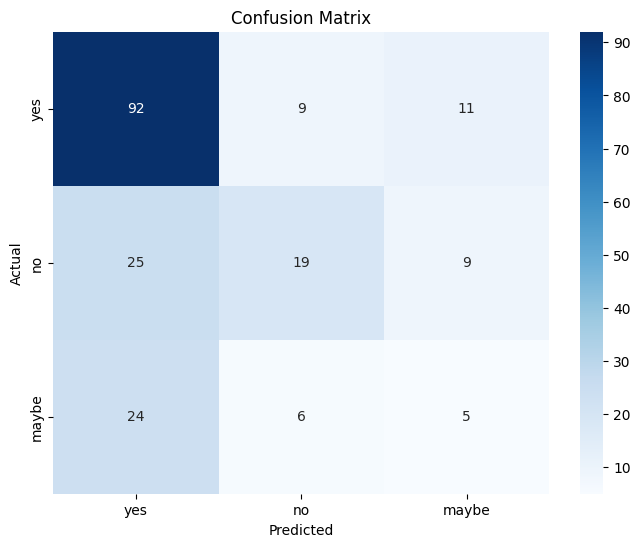

In [ ]:
# 3. Run Benchmark
rag_system.run_benchmark(sample_size=200)

In [ ]:
# 4. Launch UI
rag_system.launch_gradio_ui()


Launching Gradio UI


/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c9f3b4c1ac2f5412a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c9f3b4c1ac2f5412a9.gradio.live


In [ ]:
!python pubmedqa_rag_app.py

2025-11-24 23:27:51.430147: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 23:27:51.447307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764026871.468520   10750 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764026871.475080   10750 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764026871.491685   10750 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 